In [1]:
%matplotlib inline
# lib imports
import cv2
import glob
import time
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip

# helpful header
import helper as h

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32



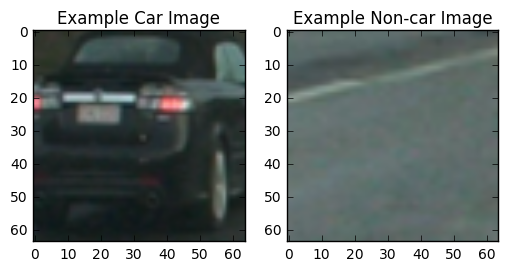

In [2]:
## Preparing images to train classifier

# import images

cars = glob.glob('vehicles/*/*.png')
notcars = glob.glob('non-vehicles/*/*.png')

# get some feel for the data
data_info = h.data_look(cars, notcars)
print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

# test a couple to make sure they're there
print()
test_car = mpimg.imread(cars[np.random.randint(0, len(cars))])
plt.subplot(121)
plt.imshow(test_car)
plt.title('Example Car Image')
test_non_car = mpimg.imread(notcars[np.random.randint(0, len(notcars))])
plt.subplot(122)
plt.imshow(test_non_car)
plt.title('Example Non-car Image')
plt.savefig('output_images/car_not_car.jpg')

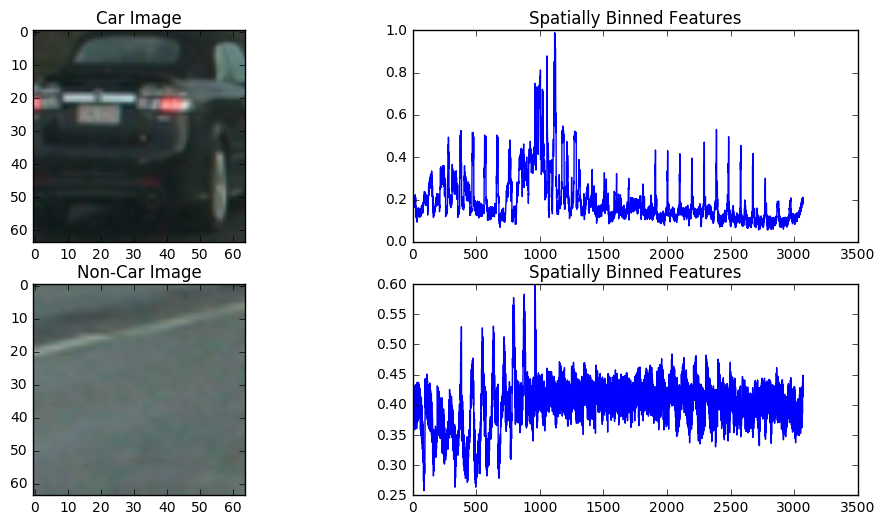

In [6]:
# HSV Histogram

# Generate a random index to look at a car image
#ind = np.random.randint(0, len(cars))
## Read in the image
#image = mpimg.imread(cars[ind])

feature_vec_car = h.bin_spatial(test_car, color_space='RGB', size=(32, 32))
feature_vec_non_car = h.bin_spatial(test_non_car, color_space='RGB', size=(32, 32))

# Plot the examples
fig = plt.figure(figsize=(12,6))
ax1 = plt.subplot2grid((2,2),(0, 0))
ax1.imshow(test_car)
plt.title('Car Image')
# Plot features
ax2 = plt.subplot2grid((2,4),(0, 2), colspan=2)
ax2.plot(feature_vec_car)
plt.title('Spatially Binned Features')
plt.savefig('output_images/spatial_binning.jpg')

ax1 = plt.subplot2grid((2,2),(1, 0))
ax1.imshow(test_non_car)
plt.title('Non-Car Image')
# Plot features
ax2 = plt.subplot2grid((2,4),(1, 2), colspan=2)
ax2.plot(feature_vec_non_car)
plt.title('Spatially Binned Features')
plt.savefig('output_images/spatial_binning.jpg')



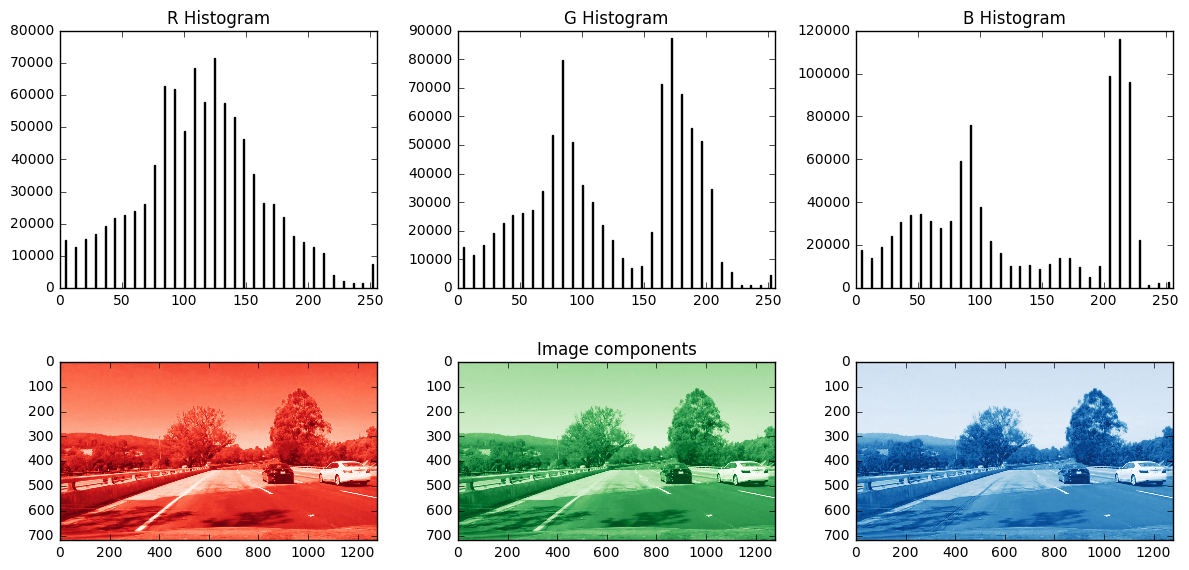

In [7]:
#Color Histogram
test_image = mpimg.imread('test_images/test4.jpg')
nbins=32
bins_range=(0, 256)

rh = np.histogram(test_image[:,:,0], bins=nbins, range=bins_range)
gh = np.histogram(test_image[:,:,1], bins=nbins, range=bins_range)
bh = np.histogram(test_image[:,:,2], bins=nbins, range=bins_range)
bin_edges = rh[1]
bincen = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2

feature_vec = h.color_hist(test_image, nbins, bins_range)

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,6))
    plt.subplot(231)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(232)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(233)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()
    
    #fig2 = plt.figure(figsize=(12,3))
    plt.subplot(234)
    plt.imshow(test_image[:,:,0],  cmap='Reds_r')
    plt.subplot(235)
    plt.imshow(test_image[:,:,1],  cmap='Greens_r')
    plt.title('Image components')
    plt.subplot(236)
    plt.imshow(test_image[:,:,2],  cmap='Blues_r')
    plt.savefig('output_images/rgb_histogram.jpg')

else:
    print('Your function is returning None for at least one variable...')

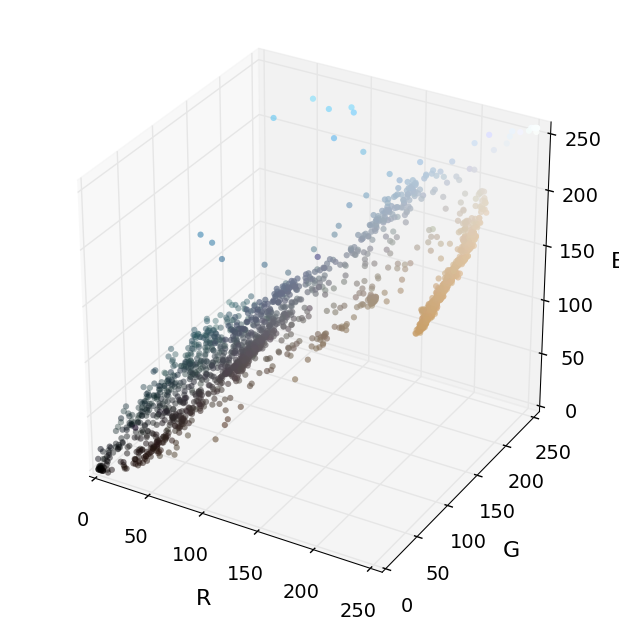

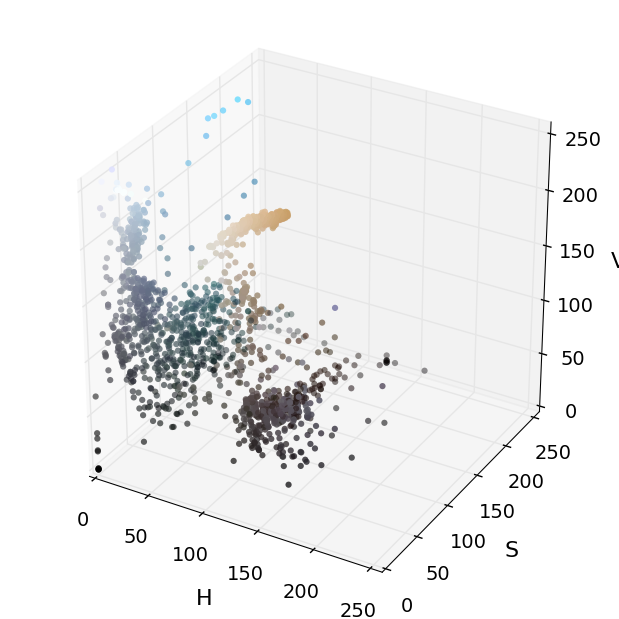

In [8]:
# Demonstrate the colours in 3D space
img = np.copy(test_image)
# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_RGB2HSV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
#figure = plt.figure(figsize=(12,3))
x1 = h.plot3d(img_small_RGB, img_small_rgb)
plt.show()

x2 = h.plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()


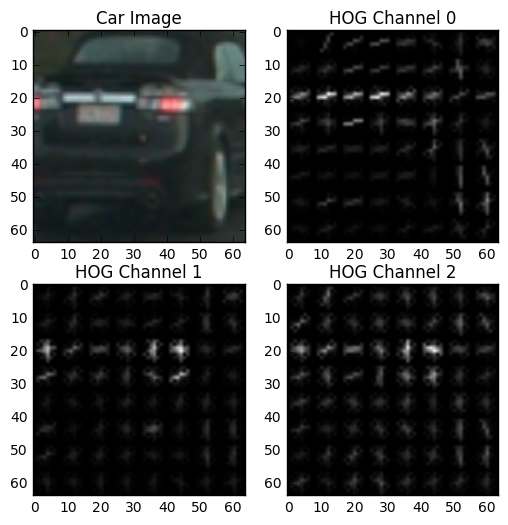

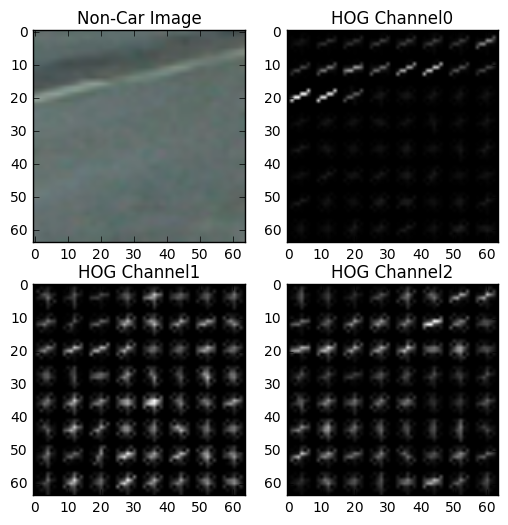

In [23]:
# Testing HOG

gray_car = cv2.cvtColor(test_car, cv2.COLOR_RGB2YCrCb)
gray_non_car = cv2.cvtColor(test_non_car, cv2.COLOR_RGB2YCrCb)

# Define HOG parameters
orient = 13
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output

# Plot the examples
fig = plt.figure(figsize=(6,6))
plt.subplot(221)
plt.imshow(test_car, cmap='gray')
plt.title('Car Image')
plt.savefig('output_images/HOG_car_visualization.jpg')


hog_features = []
for index in range(gray_car.shape[2]):
    hog_features, hog_image_car = h.get_hog_features(gray_car[:,:,index], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
    plt.subplot(222+index)
    plt.imshow(hog_image_car, cmap='gray')
    plt.title('HOG Channel '+ str(index))

# Plot for the non-car
fig = plt.figure(figsize=(6,6))
plt.subplot(221)
plt.imshow(test_non_car, cmap='gray')
plt.title('Non-Car Image')
for index in range(gray_non_car.shape[2]):
    features_non_car, hog_image_non_car = h.get_hog_features(gray_non_car[:,:,index],
                        orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
    plt.subplot(222+index)
    plt.imshow(hog_image_non_car, cmap='gray')
    plt.title('HOG Channel' + str(index))

plt.savefig('output_images/HOG_non_car_visualization.jpg')



In [33]:
# Reduce the sample size during early runs
sample_size = 4000
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

### Tweak these parameters and see how the results change.
color_space = 'YCrCb'             # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11                     # HOG orientations
pix_per_cell = 8                # HOG pixels per cell
cell_per_block = 2              # HOG cells per block
hog_channel = 'ALL'             # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16)         # Spatial binning dimensions
hist_bins = 32                  # Number of histogram bins
spatial_feat = True             # Spatial features on or off
hist_feat = True                # Histogram features on or off
hog_feat = True                 # HOG features on or off
hog_feature_vec = False         # derive hog feature every time
c_ = 1000.0


4.64 Seconds to extract HOG features...
Using: 11 orientations, 8 pixels per cell, 2 cells per block
Feature vector length: 7332


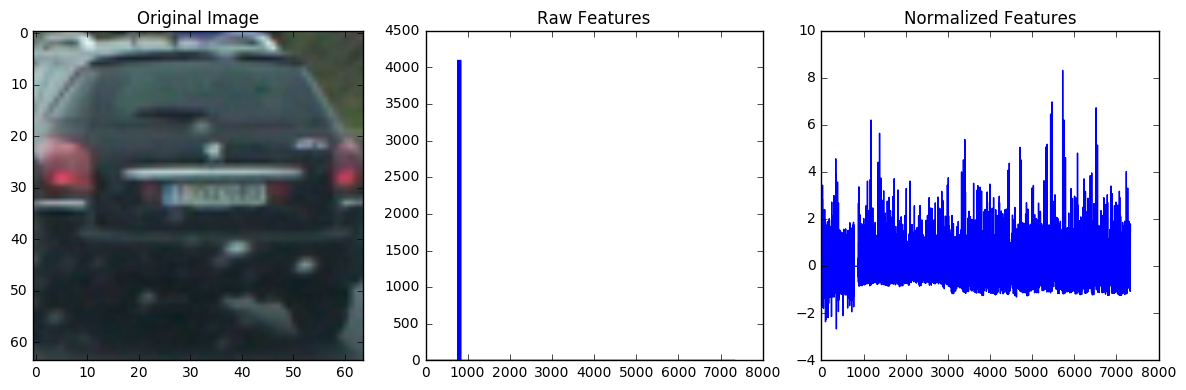

In [34]:
# Training
t=time.time()
car_features = h.extract_features(cars, 
                        color_space=color_space, 
                        spatial_size=spatial_size, 
                        hist_bins=hist_bins, 
                        orient=orient, 
                        pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, 
                        spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, 
                        hog_feat=hog_feat)

notcar_features = h.extract_features(notcars, 
                        color_space=color_space, 
                        spatial_size=spatial_size, 
                        hist_bins=hist_bins, 
                        orient=orient, 
                        pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, 
                        spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, 
                        hog_feat=hog_feat)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')


if len(car_features) == 0:
    print('Your function only returns empty feature vectors...')
else: 
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:',orient,'orientations,',pix_per_cell,
        'pixels per cell,', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))

    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
    plt.savefig('output_images/features_comparison.jpg')


In [35]:
## SVC Training and evaluation

# Use a linear SVC 
svc = LinearSVC(C=c_)
cal_svc = CalibratedClassifierCV(svc)

# Train and monitor time for the SVC
t=time.time()
cal_svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Test the accuracy for the SVC
print('Test Accuracy of SVC = ', cal_svc.score(X_test, y_test))

t=time.time()
n_predict = 100
print('My SVC predicts: \n', cal_svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: \n', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')


0.45 Seconds to train SVC...
Test Accuracy of SVC =  0.98125
My SVC predicts: 
 [ 1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  1.  1.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  0.  0.  0.  1.  0.  0.  1.  1.  1.  1.  1.  1.  1.  0.
  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.  0.  1.  1.  0.  0.  1.  1.
  0.  1.  1.  1.  1.  0.  1.  0.  1.  1.  0.  1.  1.  1.  0.  1.  1.  0.
  1.  0.  0.  1.  0.  1.  1.  0.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.
  1.  1.  0.  0.  1.  1.  1.  1.  0.  0.]
For these 100 labels: 
 [ 1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  1.  1.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  0.  0.  0.  1.  0.  0.  1.  1.  1.  1.  1.  1.  1.  0.
  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.
  0.  1.  1.  1.  1.  0.  1.  0.  1.  1.  0.  1.  1.  1.  0.  1.  1.  0.
  1.  0.  0.  1.  0.  1.  1.  0.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.
  1.  1.  0.  0.  1.  1.  1.  1.  0.  0.]
0.00967 Seconds to predict 100 labels with SVC


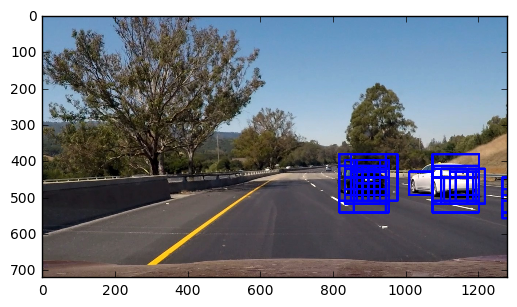

In [38]:
## Windowing

y_start_stop = [350, 550]       # Min and max in y to search in slide_window()
x_start_stop = [400, 1300]
    
#test_files = glob.glob('test_images/test*.jpg')
#for index, file in enumerate(test_files):
file = 'test_images/test6.jpg'
#image = mpimg.imread()

image = mpimg.imread(file)
draw_image = np.copy(image)
# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255
hot_windows = []
window_sizes = [64,96,128]
for window_size in window_sizes:
    windows = h.slide_window(image, x_start_stop=x_start_stop,
                         y_start_stop=y_start_stop, 
                         xy_window=(window_size, window_size), xy_overlap=(0.75, 0.75))

    hot_windows = hot_windows + h.search_windows(image, windows, cal_svc, X_scaler, 
                        color_space=color_space, 
                        spatial_size=spatial_size, 
                        hist_bins=hist_bins, 
                        orient=orient, 
                        pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, 
                        spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, 
                        hog_feat=hog_feat)                       

if (hot_windows == 0):
    print('No windows found')
else:
    window_img = h.draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    plt.figure()
    plt.imshow(window_img)
    plt.savefig('output_images/windows.jpg')


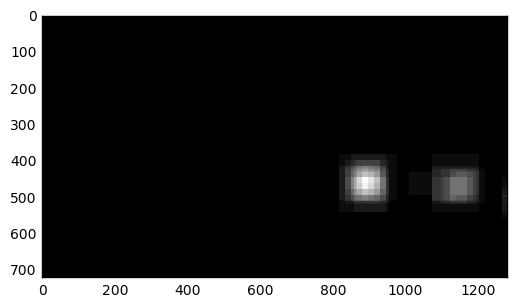

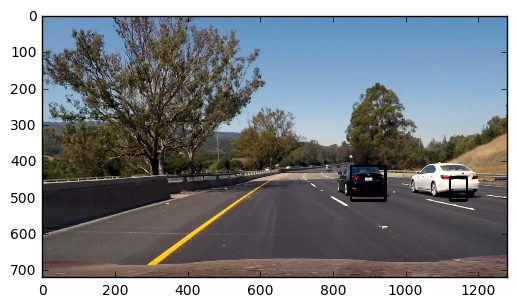

In [41]:
## Test heatmaps
testheatmap = np.zeros((image.shape[0],image.shape[1]))
testheatmap = h.add_heat(testheatmap, hot_windows)

plt.figure()
plt.imshow(testheatmap, cmap='gray')
plt.savefig('output_images/heatmaps.jpg')

testheatmap = h.apply_threshold(testheatmap, threshold=7)
labels = label(testheatmap)
draw_image = h.draw_labeled_bboxes(image, labels)
plt.figure()
plt.imshow(draw_image)
plt.savefig('output_images/bbox_heatmaps.jpg')


total number of windows: 270
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

  0%|          | 0/39 [00:00<?, ?it/s]

total number of windows: 270


  3%|▎         | 1/39 [00:13<08:30, 13.43s/it]

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 

KeyboardInterrupt: 

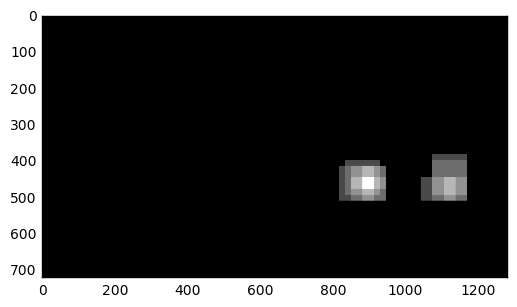

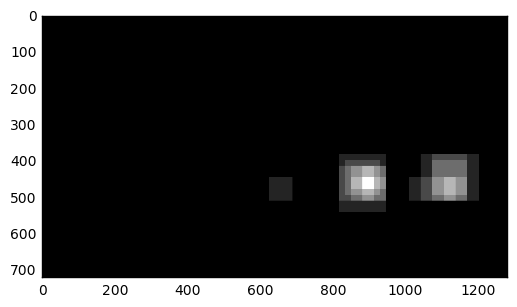

In [46]:
## Test on video

# Most of the previous pipeline has been condensed into a detection() function

def detection1(image):
    global heatmap
    if heatmap is None:
        # Initialize heatmap if non existent
        heatmap = np.zeros((image.shape[0], image.shape[1], persistence), dtype=np.int16)

    start = time.time()
    # image = cv2.resize(image, (0, 0), fx=1.0, fy=1.0 /)
    draw_image = np.copy(image)
    heatmap_disp = np.zeros((image.shape[0], image.shape[1]))
    
    image = image.astype(np.float32) / 255.0

    windows_l = h.slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop,
                             xy_window=(128, 128), xy_overlap=(0.75, 0.75))
    
    windows_m = h.slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop,
                             xy_window=(96, 96), xy_overlap=(0.5, 0.5))
    
    windows_s = h.slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop,
                             xy_window=(64, 64), xy_overlap=(0.5, 0.5))
    
    print("total number of windows: %s" % (len(windows_l) + len(windows_s)))
    
    hot_windows_l = h.search_windows(image, windows_l, cal_svc, X_scaler, 
                                    color_space=color_space, spatial_size=spatial_size, 
                                    hist_bins=hist_bins, orient=orient,  pix_per_cell=pix_per_cell,
                                    cell_per_block=cell_per_block,hog_channel=hog_channel, 
                                    spatial_feat=spatial_feat,hist_feat=hist_feat, hog_feat=hog_feat)

    hot_windows_m = h.search_windows(image, windows_m, cal_svc, X_scaler, color_space=color_space,
                                    spatial_size=spatial_size, hist_bins=hist_bins,
                                    orient=orient, pix_per_cell=pix_per_cell,
                                    cell_per_block=cell_per_block,hog_channel=hog_channel, 
                                    spatial_feat=spatial_feat,hist_feat=hist_feat, hog_feat=hog_feat)
    
    hot_windows_s = h.search_windows(image, windows_s, cal_svc, X_scaler, color_space=color_space,
                                    spatial_size=spatial_size, hist_bins=hist_bins,
                                    orient=orient, pix_per_cell=pix_per_cell,
                                    cell_per_block=cell_per_block,hog_channel=hog_channel, 
                                    spatial_feat=spatial_feat,hist_feat=hist_feat, hog_feat=hog_feat)

    # Update the queue and get the last heatmap in the first position
    heatmap[:, :, 1:] = heatmap[:, :, :-1]
    heatmap[:, :, 0] *= 0
    heatmap[:, :, 0] = h.add_heat(heatmap[:, :, 0], hot_windows_l)
    heatmap[:, :, 0] = h.add_heat(heatmap[:, :, 0], hot_windows_m)
    heatmap[:, :, 0] = h.add_heat(heatmap[:, :, 0], hot_windows_s) 
    
    # Apply the defined threshold
    heatmap_disp = h.apply_threshold(np.sum(heatmap, axis=2), 1) #TODO
    labels = label(heatmap_disp)
    print(labels[0])
    print(labels[1], 'cars found')
    plt.figure()
    plt.imshow(heatmap_disp, cmap='gray')
    return heatmap_disp
    draw_image = h.draw_labeled_bboxes(draw_image, labels)
    print("Frame processing took %s" % (time.time() - start))
    return draw_image

# Initiate testing
np.set_printoptions(threshold=np.nan)

test_video = "test_video.mp4"
clip1 = VideoFileClip(test_video)
heatmap = None 
persistence= 5  # How many heatmaps to keep in the queue
heat_thresh = 15  # min number of detections in the last 5 frames to count as valid positive
white_clip = clip1.fl_image(detection1)
white_clip.write_videofile("output_images/result_test.mp4", audio=False)


In [ ]:
heatmap = None
project_video = "project_video.mp4"
clip2 = VideoFileClip(project_video)
pink_clip = clip2.fl_image(detection1)
pink_clip.write_videofile("output_images/result_project.mp4", audio=False)

In [ ]:
# Fin